In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

df = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro.csv')

df

,x,y,z
0,42159.783600,0.000000,0.000000
1,39159.545914,15563.916303,266.913399
2,30572.229294,28909.053086,496.928223
3,17596.068412,38144.740319,671.356184
4,2068.446366,41949.706443,775.646554
...,...,...,...
995,38132.961517,21370.880108,-7532.333000
996,31399.515894,31233.289707,1828.575655
997,20906.077447,37238.565267,10967.804062
998,7871.245318,38575.122415,18731.818721


Now we want to predict X values (can change for Y, Z):

In [12]:
#Create a new dataframe with only the x column
data = df.filter(['x']) # CHANGE FOR Y,Z

#Convert the dataframe to a numpy array
dataset = data.values

#Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * 0.8 ))

training_data_len

800

In [13]:
#Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

In [64]:
# Set roll-back window
window = 60 # default was set to 60 before

In [65]:
#Create the training data set
#Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]

#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(window, len(train_data)):
    x_train.append(train_data[i-window:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(740, 60, 1)

In [66]:
#Create the testing data set
#Create a new array containing scaled values
test_data = scaled_data[training_data_len - window: , :]

#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(window, len(test_data)):
    x_test.append(test_data[i-window:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(200, 60, 1)

Model 1:

Epoch 1/10
47/47 [==============================] - 2s 47ms/step - loss: 0.0833: 1s - loss:  - ETA: 0s - loss: 0 - ETA: 0s - loss:
Epoch 2/10
47/47 [==============================] - 2s 43ms/step - loss: 9.2000e-04 - loss: 0.0 - ETA: 1s - loss - ETA: 0s - loss
Epoch 3/10
47/47 [==============================] - 2s 42ms/step - loss: 3.5476e-04
Epoch 4/10
47/47 [==============================] - 2s 42ms/step - loss: 3.0960e-04
Epoch 5/10
47/47 [==============================] - 2s 42ms/step - loss: 3.3103e-04: 1s -
Epoch 6/10
47/47 [==============================] - 2s 41ms/step - loss: 2.6927e-04
Epoch 7/10
47/47 [==============================] - 2s 41ms/step - loss: 2.1865e-04
Epoch 8/10
47/47 [==============================] - 2s 41ms/step - loss: 2.1768e-04
Epoch 9/10
47/47 [==============================] - 2s 41ms/step - loss: 1.7500e-04
Epoch 10/10
47/47 [==============================] - 2s 41ms/step - loss: 1.9380e-04


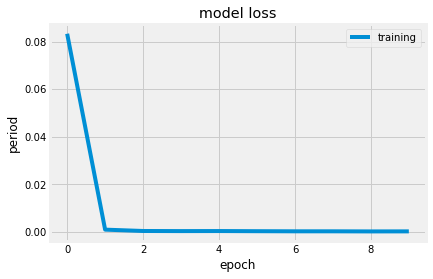

In [67]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
# Note: replace LSTM with GRU or RNN if you want to try those
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1))) # input_shape = (60,1)
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history=model.fit(x_train, y_train, batch_size=16, epochs=10)

# Plot Training Loss
plt.plot(history.history['loss']) # add validation loss
plt.title('model loss')
plt.ylabel('period')
plt.xlabel('epoch')
plt.legend(['training'], loc='upper right')
plt.show()

In [68]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

878.2505556333433

C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


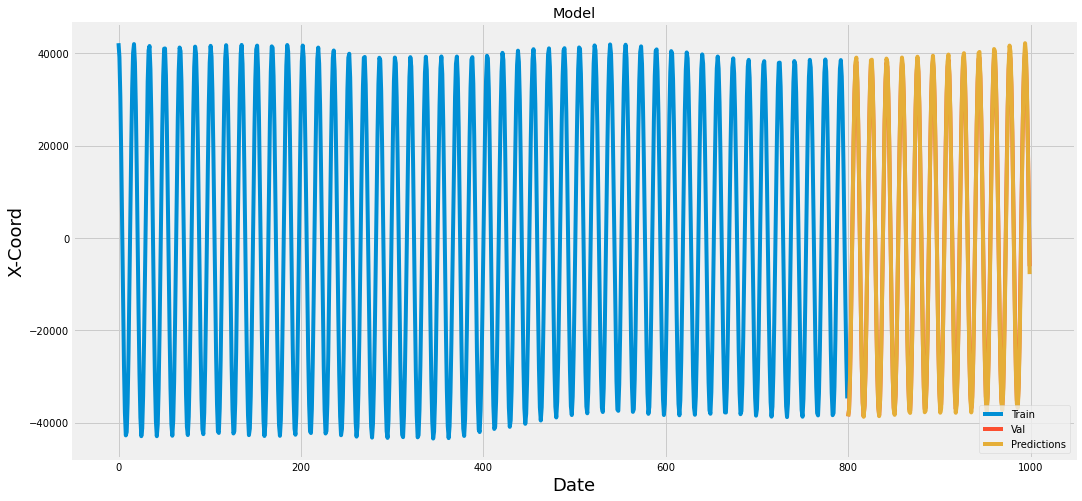

In [69]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('X-Coord', fontsize=18)
plt.plot(train['x'])
plt.plot(valid[['x', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

## Error plot:

C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:>

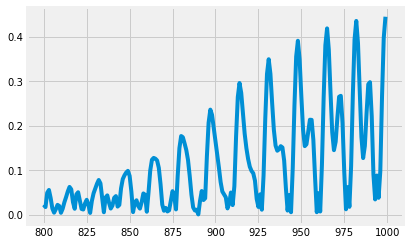

In [57]:
valid['Error']=abs(valid.Predictions-valid.x)/6738 # the normalization ct is taken as ISS semi-major axis
valid.Error.plot()